In [1]:
import sys
sys.path.insert(0, "/Users/sophusmechlenburg/PycharmProjects/python_for_the_financial_economist")

"""
Load relevant packages
"""
    
# numpy for vector and matrix calculations + simulation
import numpy as np

# pandas 
import pandas as pd

# scipy
from scipy import stats
import statsmodels.api as sm

# plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns

# pandas datareader for getting data from different APIs 
import pandas_datareader as pdr

# packages for working with dates and time
import datetime

"""
Load own functions/packages
"""

# My functions
import MyFunctions

from codelib.portfolio_optimization.risk_metrics import calculate_conditional_value_at_risk

# set plotting style
from codelib.visualization.layout import DefaultStyle
DefaultStyle();

In [2]:
# Reload MyFunctions library. Run this when updating the file while working
import importlib
importlib.reload(MyFunctions)

<module 'MyFunctions' from '/Users/sophusmechlenburg/PycharmProjects/py_fin/Master Thesis/MyFunctions.py'>

# Get data

In [3]:
from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

"""
Get the 30 industry portfolios
"""

reader = FamaFrenchReader("30_Industry_Portfolios_daily",
                          start=datetime.datetime(2000, 1, 1))

industry_port_daily = reader.read()

# print description
print(industry_port_daily['DESCR'])

industry_port_daily = industry_port_daily[0] / 100

/var/folders/vf/zf6_b41x70xg9rvm080gvn5w0000gn/T/ipykernel_6979/654296590.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port_daily = reader.read()
/var/folders/vf/zf6_b41x70xg9rvm080gvn5w0000gn/T/ipykernel_6979/654296590.py:10: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_port_daily = reader.read()


30 Industry Portfolios daily
----------------------------

This file was created by CMPT_IND_RETS_DAILY using the 202412 CRSP database. It contains value- and equal-weighted returns for 30 industry portfolios. The portfolios are constructed at the end of June. Missing data are indicated by -99.99 or -999. Copyright 2024 Eugene F. Fama and Kenneth R. French

  0 : Average Value Weighted Returns -- Daily (6289 rows x 30 cols)
  1 : Average Equal Weighted Returns -- Daily (6289 rows x 30 cols)


In [4]:
import re

file = '/Users/sophusmechlenburg/Downloads/Siccodes30 3.txt'
with open(file, 'r') as file:
    data = file.read()

# Initialize lists to store sectors and descriptions
sectors = []
descriptions = []

# Pattern to match only major sector lines (starts with a single number 1-30 followed by a word)
sector_pattern = re.compile(r'^(\d{1,2})\s+(\w+)\s+(.+)$')

# Process each line
for line in data.strip().split('\n'):
    # Check if this is a major sector line (numbered 1-30)
    sector_match = sector_pattern.match(line.strip())
    if sector_match:
        sector_num = int(sector_match.group(1))
        if 1 <= sector_num <= 30:  # Only include sectors numbered 1-30
            sector_name = sector_match.group(2)
            description = sector_match.group(3)
            sectors.append(sector_name)
            descriptions.append(description)

# Create DataFrame
df = pd.DataFrame({
    'Industry': sectors,
    'Description': descriptions
})

# Display the DataFrame
pd.set_option('display.max_colwidth', None)  # Don't truncate column content
pd.set_option('display.width', 1000)  # Set a wide display width
pd.set_option('display.expand_frame_repr', False)  # Don't wrap to multiple lines
df.index += 1
df

,Industry,Description
1,Food,Food Products
2,Beer,Beer & Liquor
3,Smoke,Tobacco Products
4,Games,Recreation
5,Books,Printing and Publishing
6,Hshld,Consumer Goods
7,Clths,Apparel
8,Hlth,"Healthcare, Medical Equipment, Pharmaceutical Products"
9,Chems,Chemicals
10,Txtls,Textiles


In [5]:
# Last 10 years
log_returns = np.log1p(industry_port_daily)
log_returns = log_returns.resample('W-FRI').sum()  # Resample to weekly (ending on Friday)
obs = len(log_returns)
log_returns = log_returns.loc["2015-01-07":"2024-12-31",:] # Include all full weeks from 2015-2024
log_returns_pd = log_returns
log_returns = log_returns.values
log_returns.shape

(521, 30)

In [6]:
log_returns_pd

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-09,0.012315,0.031474,0.024163,-0.022583,-0.016592,-0.005956,0.001592,0.022475,-0.010087,0.014101,...,-0.010899,-0.014249,0.006694,-0.009764,-0.028613,-0.000393,0.006627,0.005098,-0.031619,-0.012580
2015-01-16,-0.003690,0.006545,0.023244,-0.007905,0.002695,0.006175,-0.027787,0.003261,-0.002972,0.008463,...,0.005108,-0.010979,-0.035817,-0.001286,-0.007677,-0.016623,-0.017903,-0.008087,-0.030267,-0.006864
2015-01-23,0.012438,0.015069,0.011846,0.036140,0.022970,-0.001837,0.017203,0.003424,0.001632,0.023203,...,-0.006692,0.026783,0.032594,0.001761,0.036442,0.017977,0.024206,0.021710,0.015616,0.014797
2015-01-30,-0.036161,-0.041847,-0.023478,0.008020,-0.012490,-0.040535,-0.019847,-0.017820,-0.009714,-0.018556,...,-0.031343,-0.047075,-0.023925,-0.012843,-0.040856,-0.023933,-0.011284,-0.004860,-0.032936,-0.030585
2015-02-06,0.016886,0.026664,0.009492,0.018850,0.048547,0.025376,-0.003419,0.002446,0.049266,0.024443,...,0.064840,0.030609,0.028793,0.031588,0.019172,0.030117,0.037495,0.009820,0.055875,0.033119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-29,0.013352,0.008294,0.021285,0.001326,0.000015,0.014151,0.023169,0.022917,0.005203,0.000776,...,0.016859,0.009590,0.002061,0.006833,0.013731,0.009916,0.035391,0.011204,0.010552,0.013072
2024-12-06,-0.026871,-0.014518,-0.015041,0.034428,0.003147,-0.020522,0.047100,-0.006626,-0.027809,-0.046440,...,-0.003249,0.039904,0.025514,-0.027116,-0.037889,-0.012056,0.047317,0.011001,-0.021761,-0.023325
2024-12-13,0.009122,0.005109,-0.034497,-0.017552,-0.020964,-0.011005,-0.007087,-0.026585,-0.030016,-0.012465,...,-0.032177,-0.002297,0.004395,-0.011943,-0.019993,-0.028490,-0.005724,-0.023515,-0.023695,-0.028550


# PCA

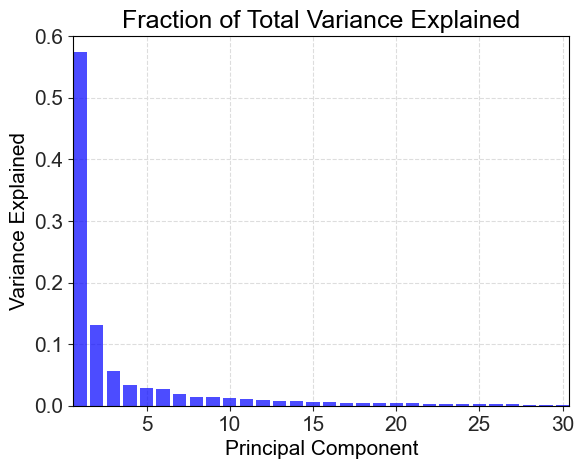

[0.57375164 0.70444925 0.76032224 0.79360707 0.82250785 0.85028708
 0.87002921 0.88497628 0.89866045 0.91096086 0.92135334 0.93032264
 0.93875171 0.94573671 0.95193612 0.95761233 0.96263629 0.96754177
 0.97168202 0.9754487  0.97916873 0.98247988 0.98557728 0.98829167
 0.99085298 0.99308228 0.99506739 0.99697121 0.99868811 1.        ]


In [7]:
mean_vector, eig_values, eig_vectors, PC = MyFunctions.calculate_PCA(log_returns_pd, 30)
PC4 = PC.iloc[:, :4]

total_variance = np.sum(eig_values)
proportion_explained = eig_values / total_variance
cum_explained = np.cumsum(proportion_explained)


plt.bar(range(1, len(proportion_explained) + 1), proportion_explained, color='blue', alpha=0.7)
plt.ylim(0, 0.6)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Fraction of Total Variance Explained')

# Show the plot
plt.show()

# Print cumulative explained variance
print(cum_explained)

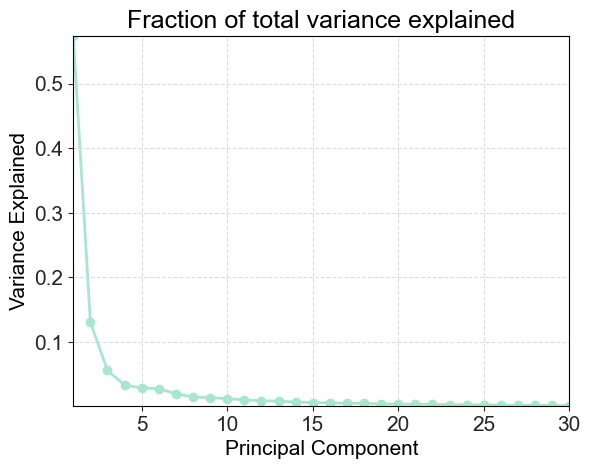

[0.57375164 0.70444925 0.76032224 0.79360707 0.82250785 0.85028708
 0.87002921 0.88497628 0.89866045 0.91096086 0.92135334 0.93032264
 0.93875171 0.94573671 0.95193612 0.95761233 0.96263629 0.96754177
 0.97168202 0.9754487  0.97916873 0.98247988 0.98557728 0.98829167
 0.99085298 0.99308228 0.99506739 0.99697121 0.99868811 1.        ]


In [8]:
# Scree plot / Elbow method would suggest using 4 PCs

plt.plot(range(1, len(proportion_explained) + 1), proportion_explained, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Fraction of total variance explained')
plt.show()
print(cum_explained)

In [9]:
mean_vector * 52

Food     0.057726
Beer     0.068361
Smoke    0.090212
Games    0.128871
Books    0.040237
Hshld    0.067068
Clths    0.059269
Hlth     0.081482
Chems    0.051114
Txtls   -0.018502
Cnstr    0.149638
Steel    0.082334
FabPr    0.134699
ElcEq    0.064987
Autos    0.184163
Carry    0.098021
Mines    0.105632
Coal    -0.021352
Oil      0.046423
Util     0.075170
Telcm    0.045482
Servs    0.164868
BusEq    0.206539
Paper    0.036497
Trans    0.071472
Whlsl    0.102642
Rtail    0.141529
Meals    0.119995
Fin      0.116710
Other    0.097704
dtype: float64

In [10]:
# Check that results are correct

from sklearn.decomposition import PCA

# Sample data (replace with your own dataset)
X = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Initialize PCA with the number of components you want
pca = PCA(n_components=4)

# Fit and transform the data
principal_components_scikit = pca.fit_transform(log_returns)

# Access the explained variance ratio
explained_variance = pca.explained_variance_ratio_

test = np.round(PC4.values, 8) == np.round(principal_components_scikit, 8)
print("Explained Variance Ratio:", explained_variance)
print(test)

Explained Variance Ratio: [0.57375164 0.13069761 0.05587299 0.03328483]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 ...
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]


In [11]:
false_count = np.sum(~test)
false_count

0

# Errors

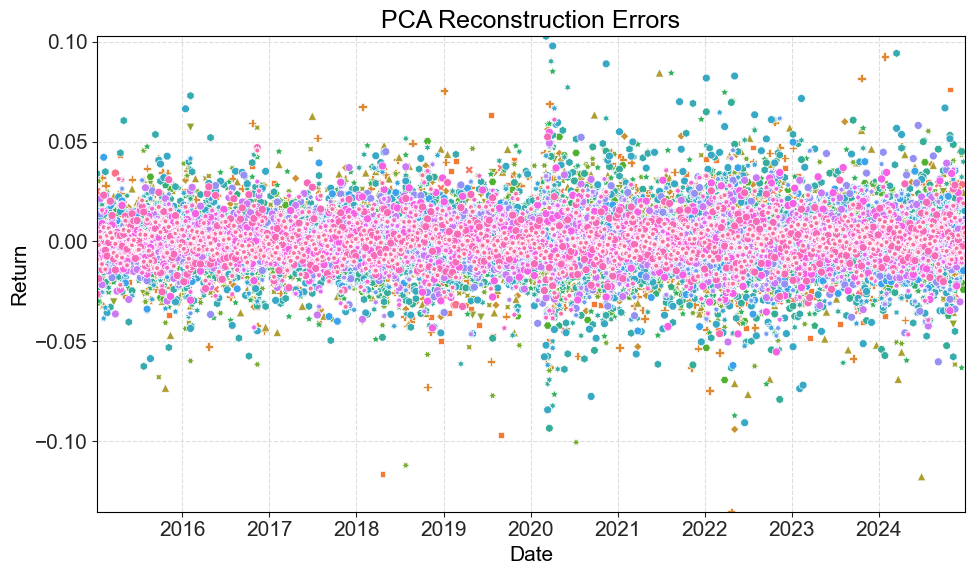

In [12]:
# Reconstruct log returns using only the first 4 PCs
reconstructed_centered = PC4.values @ eig_vectors[:, :4].T # using eig_vectors as loading/coefficients
reconstructed_returns = reconstructed_centered + mean_vector.values

# Calculate errors (what the 4 PCs cannot explain)
errors = log_returns - reconstructed_returns
errors_pd = pd.DataFrame(errors, index=log_returns_pd.index)

# Plot errors
plt.figure(figsize=(10, 6))
sns.scatterplot(data=errors_pd, legend=False)
plt.title('PCA Reconstruction Errors')
plt.ylabel("Return")
plt.tight_layout()
plt.show()

# Simulation

In [13]:
pd.DataFrame(MyFunctions.fit_t_distributions(errors))

,0,1,2
0,8.101349,0.000026,0.008558
1,11.648130,0.000014,0.011189
2,3.862802,0.000356,0.013150
3,4.698854,0.000234,0.017116
4,7.154385,-0.000033,0.014466
5,7.355062,0.000023,0.009466
6,4.618008,-0.000073,0.016525
7,5.460540,0.000110,0.011753
8,6.480576,-0.000036,0.010240
9,4.673131,0.001052,0.015849


In [14]:
print(PC4.values.shape)
print(errors.shape)

factor_error_returns = np.concatenate((PC4.values, errors), axis=1)
print(factor_error_returns.shape)

(521, 4)
(521, 30)
(521, 34)


In [15]:
risk_free = 0.0449 # As of 2024-12-31, https://www.newyorkfed.org/markets/reference-rates/sofr
risk_free = np.log(1 + risk_free) # convert to log to be consistent
risk_free

0.043921187057928086

In [16]:
mean_vector*52

Food     0.057726
Beer     0.068361
Smoke    0.090212
Games    0.128871
Books    0.040237
Hshld    0.067068
Clths    0.059269
Hlth     0.081482
Chems    0.051114
Txtls   -0.018502
Cnstr    0.149638
Steel    0.082334
FabPr    0.134699
ElcEq    0.064987
Autos    0.184163
Carry    0.098021
Mines    0.105632
Coal    -0.021352
Oil      0.046423
Util     0.075170
Telcm    0.045482
Servs    0.164868
BusEq    0.206539
Paper    0.036497
Trans    0.071472
Whlsl    0.102642
Rtail    0.141529
Meals    0.119995
Fin      0.116710
Other    0.097704
dtype: float64

In [17]:
""" Create a function that simulates """

' Create a function that simulates '

In [18]:
# 1. Separate joint factor & error distribution into marginals and copula
J, N = factor_error_returns.shape
probabilities = np.repeat(1/J, J)
x, u, U = MyFunctions.CMA_separation(factor_error_returns, probabilities)

# 2. Fit t-distributions to PC4 & errors
t_params_PC4 = MyFunctions.fit_t_distributions(factor_error_returns[:, :4])
half_point = int(J / 2) # error distributions using 5-year historical data, consistent with exposure to factors
t_params_errors = MyFunctions.fit_t_distributions(factor_error_returns[half_point:, 4:])
t_params = t_params_PC4 + t_params_errors # concatenate 2 lists
t_params = pd.DataFrame(t_params, columns=["df", "loc", "scale"])
t_params["loc"] = 0 # error terms have zero expected return
""" PC4 also set loc=0; confirm"""

# 3. Simulate returns using empirical copula with t-marginals
simulations = 1000 * 52 # 1,000 52-week returns
sampled_indices = np.random.choice(len(U), size=simulations, p=probabilities) # sample index
U_simulated = U[sampled_indices] # Get the corresponding copula samples

# Amplify volatility of panic observations
panic_indices = [271, 272, 270, 274, 273]
panic_mask = np.isin(sampled_indices, panic_indices)
panic_positions = np.where(panic_mask)[0]
panic_observations = len(panic_positions)
amplifier = np.random.uniform(1, 2, size=panic_observations)

#simulated_returns_no_alpha[panic_positions] *= amplifier[:, np.newaxis] # multiply panic returns row-wise with amplifier values

simulated_components = np.zeros((simulations, N))

for j in range(N):
    df, loc, scale = t_params.values[j]
    simulated_components[:, j] = stats.t.ppf(U_simulated[:, j], df=df, loc=loc, scale=scale)
    # Increasing volatility for panic observations
    for i, pos in enumerate(panic_positions):
        scale_panic = scale * amplifier[i] # using a specific amplifier for each panic observation
        simulated_components[pos, j] = stats.t.ppf(U_simulated[pos, j], df=df, loc=loc, scale=scale_panic)

# Step 4: Combine PC4 and errors
exposures = pd.DataFrame(index=["Alpha", "PC1", "PC2", "PC3", "PC4"], columns=log_returns_pd.columns)
sectors = 30
# Estimating factor exposure
for sector in range(sectors):
    y = log_returns[half_point:, sector] #only use most recent 5 years
    X = sm.add_constant(PC4.iloc[half_point:, :])
    model = sm.OLS(y, X).fit()
    exposures.iloc[:, sector] = model.params
exposures = exposures.astype(float)

simulated_PC4 = simulated_components[:, :4]
simulated_errors = simulated_components[:, 4:]

simulated_returns = simulated_PC4 @ exposures.iloc[1:, :].values + simulated_errors
simulated_returns_no_alpha = mean_vector.values + simulated_PC4 @ exposures.iloc[1:, :].values + simulated_errors

# Finding expected return vector which sets sector Sharpe ratios = 0.15
# The target is based on the average historical SR using current risk-free rate
sector_sd = np.std(simulated_returns, axis=0)
target_SR = 0.15
target_SR_weekly = target_SR * (np.sqrt(52) / 52)
risk_free_linear = 0.0449 # As of 2024-12-31, https://www.newyorkfed.org/markets/reference-rates/sofr
risk_free = np.log(1 + risk_free_linear) # convert to log-return to be consistent
risk_free_weekly = risk_free / 52
risk_free_weekly_linear = (1 + risk_free_linear) ** (1/52) - 1 # used in later analysis
expected_return_weekly = target_SR_weekly * sector_sd + risk_free_weekly

simulated_returns += expected_return_weekly - np.mean(simulated_returns, axis=0)

simulated_returns_log = simulated_returns
simulated_returns_linear = np.exp(simulated_returns) - 1
print(simulated_returns.shape)

# 4. Analyze the simulated returns
simulated_stats = MyFunctions.compute_returns_statistics(simulated_returns, risk_free=risk_free)
simulated_stats.index=log_returns_pd.columns
#simulated_stats.drop(["VaR 99% (%)", "JB p-value"], axis=1, inplace=True)
simulated_stats.round(2)

(52000, 30)


,Mean (%),Median (%),Std Dev (%),Min (%),Max (%),Skewness,Kurtosis,VaR 95% (%),CVaR 95% (%),Ann. Return (%),Ann. Volatility (%),Ann. Sharpe Ratio,Max Drawdown (%),JB p-value
Food,0.13,0.27,2.18,-18.46,13.03,-0.82,8.33,-3.04,-5.11,6.75,15.73,0.15,-70.90,0.0
Beer,0.14,0.31,2.69,-28.20,26.05,-0.43,21.16,-3.43,-5.81,7.30,19.39,0.15,-69.69,0.0
Smoke,0.15,0.35,2.99,-33.53,20.17,-1.60,16.28,-4.50,-6.88,7.63,21.59,0.15,-85.76,0.0
Games,0.16,0.12,3.73,-21.15,16.89,-0.12,2.09,-5.59,-8.08,8.43,26.91,0.15,-96.76,0.0
Books,0.15,0.28,3.32,-21.44,22.24,-0.03,3.68,-5.28,-7.22,7.98,23.94,0.15,-88.08,0.0
Hshld,0.13,0.23,2.25,-17.56,12.49,-0.55,5.55,-3.45,-5.27,6.83,16.22,0.15,-65.50,0.0
Clths,0.17,0.25,3.89,-25.24,28.59,0.29,5.97,-5.57,-8.41,8.60,28.07,0.15,-91.76,0.0
Hlth,0.13,0.16,2.33,-14.48,11.67,-0.18,2.67,-3.62,-5.24,6.91,16.81,0.15,-70.34,0.0
Chems,0.15,0.16,3.15,-18.71,32.41,0.89,12.28,-4.66,-6.91,7.80,22.74,0.15,-91.87,0.0
Txtls,0.21,0.24,6.02,-65.60,54.97,-0.29,25.54,-6.38,-12.76,10.91,43.42,0.15,-99.08,0.0


In [19]:
linear_returns = np.exp(log_returns) - 1
original_stats_linear = MyFunctions.compute_returns_statistics(linear_returns, risk_free=risk_free)
original_stats_linear.head()

,Mean (%),Median (%),Std Dev (%),Min (%),Max (%),Skewness,Kurtosis,VaR 95% (%),CVaR 95% (%),Ann. Return (%),Ann. Volatility (%),Ann. Sharpe Ratio,Max Drawdown (%),JB p-value
Sector_1,0.131931,0.227829,2.032993,-12.101824,8.012449,-0.816590,4.969571,-2.945022,-4.861672,6.860409,14.660121,0.168368,-25.099756,6.792762e-127
Sector_2,0.158678,0.300285,2.322618,-16.013774,15.307743,-0.389425,9.550781,-3.191305,-5.106143,8.251265,16.748639,0.230415,-28.826001,0.000000e+00
Sector_3,0.217138,0.544901,2.918301,-18.939657,11.780493,-1.139125,5.585753,-4.615331,-7.073201,11.291156,21.044166,0.327836,-38.189378,9.945593e-169
Sector_4,0.318465,0.295895,3.745499,-15.734707,11.896996,-0.193202,1.654082,-5.726622,-8.135858,16.560206,27.009180,0.450517,-54.743510,6.693494e-14
Sector_5,0.129077,0.273017,3.206130,-17.023207,15.103078,-0.267988,2.868195,-4.921990,-7.275740,6.712018,23.119733,0.100343,-44.498210,8.326822e-40


In [20]:
original_stats = MyFunctions.compute_returns_statistics(log_returns, risk_free=risk_free)
original_stats.index=log_returns_pd.columns
original_stats.round(2)

,Mean (%),Median (%),Std Dev (%),Min (%),Max (%),Skewness,Kurtosis,VaR 95% (%),CVaR 95% (%),Ann. Return (%),Ann. Volatility (%),Ann. Sharpe Ratio,Max Drawdown (%),JB p-value
Food,0.11,0.23,2.05,-12.90,7.71,-1.02,5.79,-2.99,-5.01,5.77,14.78,0.09,-26.49,0.0
Beer,0.13,0.30,2.34,-17.45,14.24,-0.79,10.50,-3.24,-5.29,6.84,16.85,0.15,-30.76,0.0
Smoke,0.17,0.54,2.97,-21.00,11.14,-1.44,7.35,-4.73,-7.41,9.02,21.42,0.22,-44.20,0.0
Games,0.25,0.30,3.76,-17.12,11.24,-0.40,2.03,-5.90,-8.53,12.89,27.10,0.31,-57.20,0.0
Books,0.08,0.27,3.22,-18.66,14.07,-0.51,3.34,-5.05,-7.59,4.02,23.25,-0.02,-48.33,0.0
Hshld,0.13,0.25,2.19,-12.49,9.16,-0.71,4.68,-3.35,-5.25,6.71,15.77,0.15,-27.83,0.0
Clths,0.11,0.25,3.56,-16.91,15.14,-0.33,3.09,-5.42,-8.16,5.93,25.69,0.06,-49.74,0.0
Hlth,0.16,0.32,2.40,-12.21,8.55,-0.52,2.55,-3.82,-5.68,8.15,17.33,0.22,-23.63,0.0
Chems,0.10,0.16,3.01,-15.59,19.29,-0.24,5.70,-4.72,-7.23,5.11,21.67,0.03,-44.55,0.0
Txtls,-0.04,0.26,5.25,-43.33,30.06,-1.07,14.33,-6.58,-12.74,-1.85,37.85,-0.16,-76.00,0.0


In [21]:
original_stats["Ann. Sharpe Ratio"].mean()

0.201871571186487

## Normal observations vs Panic state

In [22]:
calm_simulated = simulated_returns_no_alpha[~panic_mask] # ~ NOT operator flips True and False
MyFunctions.compute_returns_statistics(calm_simulated).head()

,Mean (%),Median (%),Std Dev (%),Min (%),Max (%),Skewness,Kurtosis,VaR 95% (%),CVaR 95% (%),Ann. Return (%),Ann. Volatility (%),Ann. Sharpe Ratio,Max Drawdown (%),JB p-value
Sector_1,0.115727,0.245214,1.892728,-8.750813,6.892360,-0.401746,1.529747,-3.045308,-4.376988,6.017820,13.648659,0.440909,-69.507253,0.000000e+00
Sector_2,0.128685,0.308897,2.116609,-9.703796,6.861256,-0.237483,1.560029,-3.367042,-4.622554,6.691602,15.263082,0.438418,-65.714065,0.000000e+00
Sector_3,0.193739,0.382116,2.592136,-13.224534,7.591759,-0.526213,1.220285,-4.397404,-5.818352,10.074413,18.692156,0.538965,-67.534357,0.000000e+00
Sector_4,0.240886,0.215910,3.555316,-16.083541,11.454001,-0.127598,1.378262,-5.415281,-7.533044,12.526048,25.637747,0.488578,-90.301699,0.000000e+00
Sector_5,0.101005,0.213014,3.062684,-10.085825,10.273326,-0.014909,0.782723,-5.206867,-6.545774,5.252271,22.085326,0.237817,-94.158113,3.752965e-286


# Portfolios

## Empirical characteristics

In [23]:
linear_returns = np.exp(log_returns) - 1

ew_weight = np.repeat(1/30, 30)
ew_returns = linear_returns @ ew_weight
print(ew_returns.shape)

(521,)


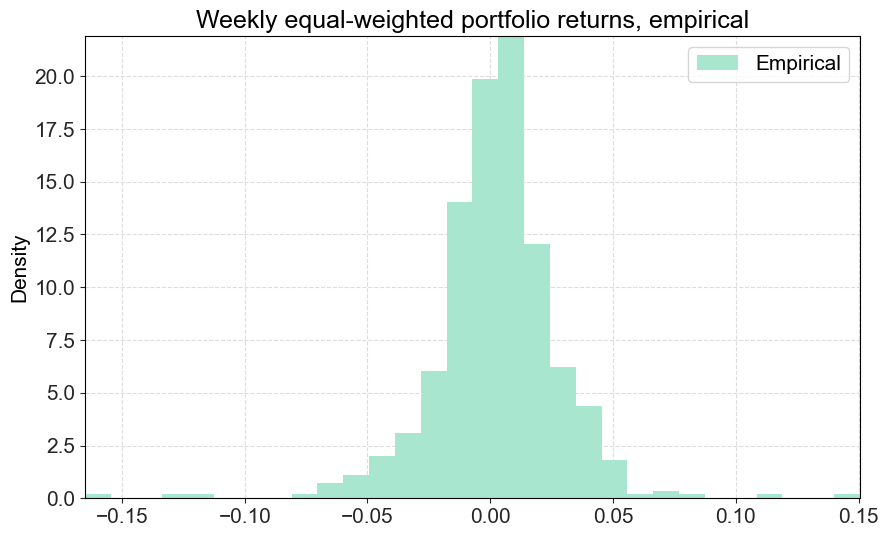

In [24]:
# Plotting

#x_values = np.linspace(0.5, 2.0, 1000)
#true_mean = 0.07
#true_vol = np.sqrt(cov_mat[1, 1])
#pdf_values = stats.lognorm.pdf(x=x_values, s=true_vol, scale=np.exp(true_mean))
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(ew_returns, bins=30, density=True, label="Empirical")
#ax.plot(x_values, pdf_values, color="black", label="True")
ax.set(title="Weekly equal-weighted portfolio returns, empirical", ylabel="Density")
ax.legend()
plt.show()

In [25]:
MyFunctions.compute_returns_statistics(pd.DataFrame(ew_returns))

,Mean (%),Median (%),Std Dev (%),Min (%),Max (%),Skewness,Kurtosis,VaR 95% (%),CVaR 95% (%),Ann. Return (%),Ann. Volatility (%),Ann. Sharpe Ratio,Max Drawdown (%),JB p-value
0,0.233013,0.318028,2.577605,-16.508573,15.052977,-0.503964,7.687387,-3.84844,-5.977934,12.116682,18.587378,0.651877,-34.511587,6.274386e-278


## Simulation characteristics

In [26]:
ew_returns_simulated = simulated_returns_linear @ ew_weight
print(ew_returns_simulated.shape)

(52000,)


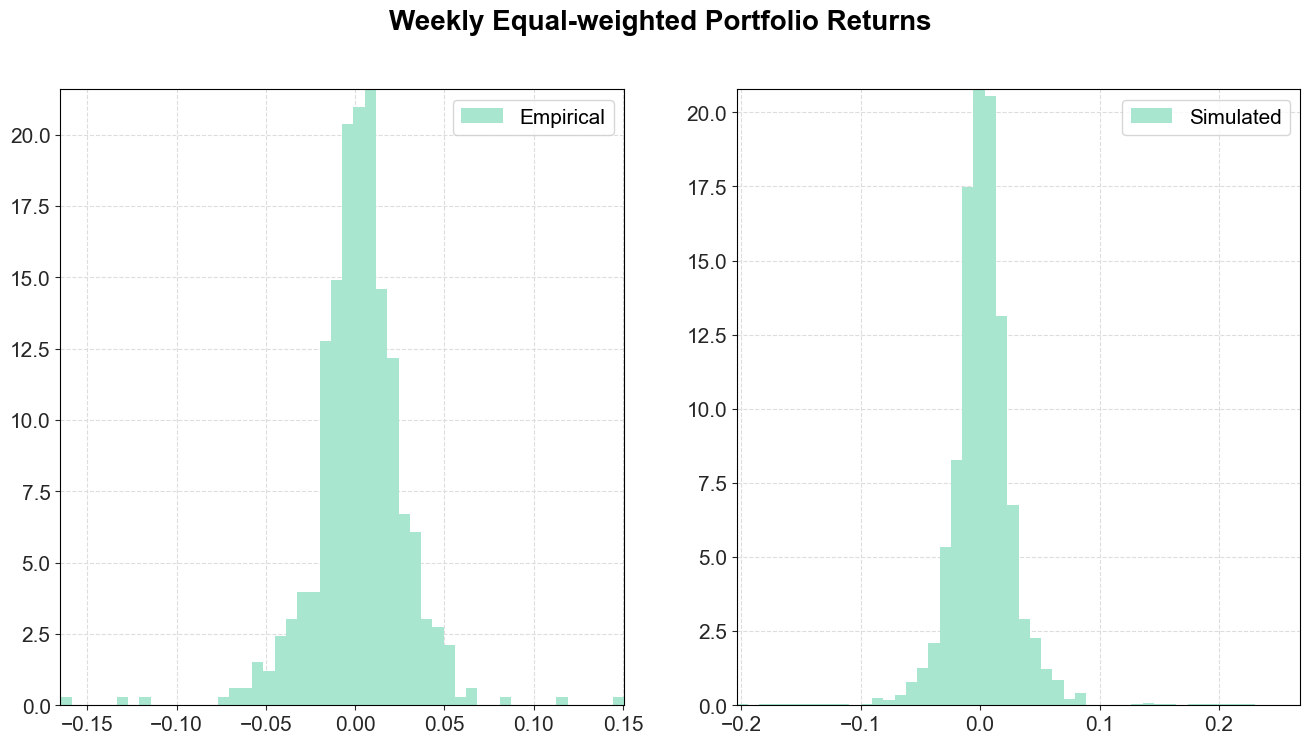

In [27]:
# Plotting


fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].hist(ew_returns, bins=50, density=True, label="Empirical")
ax[1].hist(ew_returns_simulated, bins=50, density=True, label="Simulated")
ax[0].legend()
ax[1].legend()
fig.suptitle("Weekly Equal-weighted Portfolio Returns", fontsize=20, weight="bold")
plt.show()

In [28]:
MyFunctions.compute_returns_statistics(pd.DataFrame(ew_returns_simulated))

,Mean (%),Median (%),Std Dev (%),Min (%),Max (%),Skewness,Kurtosis,VaR 95% (%),CVaR 95% (%),Ann. Return (%),Ann. Volatility (%),Ann. Sharpe Ratio,Max Drawdown (%),JB p-value
0,0.230836,0.204562,2.742823,-20.368673,26.802447,0.825941,14.898453,-3.575625,-5.721918,12.003451,19.778776,0.606885,-70.724056,0.0


In [29]:
MyFunctions.compute_returns_statistics(pd.DataFrame(ew_returns_simulated[:521]))

,Mean (%),Median (%),Std Dev (%),Min (%),Max (%),Skewness,Kurtosis,VaR 95% (%),CVaR 95% (%),Ann. Return (%),Ann. Volatility (%),Ann. Sharpe Ratio,Max Drawdown (%),JB p-value
0,0.249949,0.232524,2.922841,-15.112326,25.921173,1.457591,19.849126,-3.380419,-5.842284,12.997331,21.076907,0.616662,-29.203215,0.0


In [30]:
# Amplify volatility of panic observations
panic_indices = [271, 272, 270, 274, 273]
panic_mask = np.isin(sampled_indices, panic_indices)
panic_positions = np.where(panic_mask)[0]
panic_observations = len(panic_positions)
amplifier = np.random.uniform(1, 2, size=panic_observations)

#simulated_returns_no_alpha[panic_positions] *= amplifier[:, np.newaxis] # multiply panic returns row-wise with amplifier values

simulated_returns_temp = np.zeros((simulations, N))

for j in range(N):
    df, loc, scale = t_params.values[j]
    simulated_returns_temp[:, j] = stats.t.ppf(U_simulated[:, j], df=df, loc=loc, scale=scale)
    # Increasing volatility for panic observations
    for i, pos in enumerate(panic_positions):
        scale_panic = scale * amplifier[i] # using a specific amplifier for each panic observation
        simulated_returns_temp[pos, j] = stats.t.ppf(U_simulated[pos, j], df=df, loc=loc, scale=scale_panic)

In [31]:
# Panic

panic_indices = [271, 272, 270, 274, 273]
panic_PC4 = PC4.iloc[panic_indices]
panic_U = U[panic_indices]

amplifier = np.random.uniform(1, 2, size=5)

simulated_returns_calc = np.zeros((5, N))
simulated_returns_calm = np.zeros((5, N))

for j in range(N):
    for i in range(5):
        df, loc, scale = t_params.iloc[j]
        scale_panic = scale * amplifier[i] # using a specific amplifier for each panic observation
        simulated_returns_calc[i, j] = stats.t.ppf(panic_U[i, j], df=df, loc=loc, scale=scale_panic)
        simulated_returns_calm[i, j] = stats.t.ppf(panic_U[i, j], df=df, loc=loc, scale=scale)

panic_PC4 = simulated_returns_calc[:, :4]
panic_errors = simulated_returns_calc[:, 4:]
panic_returns_no_alpha = mean_vector.values + panic_PC4 @ exposures.iloc[1:, :].values + panic_errors

calm_PC4 = simulated_returns_calm[:, :4]
calm_errors = simulated_returns_calm[:, 4:]
calm_returns_no_alpha = mean_vector.values + calm_PC4 @ exposures.iloc[1:, :].values + calm_errors


pd.DataFrame(panic_returns_no_alpha)



,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.180211,-0.275148,-0.326771,-0.053816,-0.209800,-0.171319,-0.194479,-0.140798,-0.182826,-0.642174,...,-0.204154,-0.174478,-0.181821,-0.136069,-0.165965,-0.241560,-0.033445,-0.315578,-0.305576,-0.186159
1,0.087513,0.191587,0.148833,0.125263,0.055135,0.091990,0.209745,0.081174,0.108391,0.372231,...,0.083500,0.094221,0.119971,0.096679,0.194408,0.152600,0.051403,0.166091,0.169558,0.102946
2,-0.088154,-0.103875,-0.056744,-0.121397,-0.044240,-0.050842,-0.146576,-0.060607,-0.089020,-0.197304,...,-0.044152,-0.022835,-0.031290,-0.064594,-0.099958,-0.094650,-0.040329,-0.110031,-0.070966,-0.064181
3,0.086800,0.119430,0.053063,0.108503,0.147516,0.036762,0.174382,0.078303,0.215395,0.363473,...,0.107955,0.117004,0.094216,0.106383,0.127974,0.163273,0.085677,0.221455,0.197721,0.090124
4,0.050452,0.030242,0.057755,-0.073643,-0.101793,0.025902,-0.115208,0.053022,-0.068224,-0.268128,...,-0.021144,-0.026077,-0.021820,-0.008784,-0.095303,-0.077763,-0.003337,-0.104817,-0.093468,-0.021272


In [32]:
pd.DataFrame(calm_returns_no_alpha)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,-0.092072,-0.140761,-0.167087,-0.026452,-0.107442,-0.087415,-0.099390,-0.071595,-0.093478,-0.330191,...,-0.104491,-0.088124,-0.091509,-0.069586,-0.084623,-0.123180,-0.015864,-0.161056,-0.155947,-0.094755
1,0.060370,0.131815,0.102623,0.086691,0.038058,0.063498,0.144213,0.056166,0.074650,0.255185,...,0.057544,0.065618,0.083531,0.066529,0.133768,0.105282,0.036110,0.114640,0.116997,0.071197
2,-0.075847,-0.089372,-0.048681,-0.104318,-0.038034,-0.043654,-0.126210,-0.052035,-0.076611,-0.170150,...,-0.037944,-0.019249,-0.026428,-0.055592,-0.085987,-0.081328,-0.034394,-0.094543,-0.060872,-0.055073
3,0.065956,0.090698,0.040578,0.082712,0.111820,0.028133,0.132240,0.059637,0.163238,0.274970,...,0.081907,0.089314,0.072264,0.080675,0.097178,0.124036,0.065498,0.168147,0.150171,0.068658
4,0.036911,0.022303,0.042381,-0.052752,-0.073645,0.019147,-0.083278,0.038901,-0.049231,-0.194641,...,-0.015101,-0.018050,-0.014742,-0.006180,-0.068771,-0.055880,-0.001674,-0.075418,-0.067200,-0.014919


In [33]:
log_returns_pd.iloc[panic_indices]

,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-20,-0.128991,-0.174517,-0.209976,-0.102142,-0.186609,-0.124873,-0.163222,-0.122130,-0.155896,-0.433303,...,-0.153884,-0.145784,-0.152654,-0.129749,-0.154943,-0.188770,-0.068745,-0.212454,-0.222273,-0.149863
2020-03-27,0.071684,0.142434,0.111367,0.107845,0.057319,0.069511,0.151372,0.074786,0.083794,0.265029,...,0.070914,0.084393,0.098688,0.077850,0.145306,0.117216,0.054731,0.122547,0.127351,0.084754
2020-03-13,-0.098861,-0.112081,-0.077687,-0.153905,-0.096757,-0.073726,-0.169140,-0.087184,-0.126647,-0.245243,...,-0.074867,-0.067905,-0.075392,-0.104288,-0.138295,-0.130827,-0.074593,-0.128335,-0.100027,-0.094039
2020-04-10,0.077076,0.097688,0.050109,0.109714,0.140658,0.042951,0.149978,0.081770,0.192858,0.300622,...,0.100675,0.108758,0.098562,0.106217,0.123151,0.146506,0.086017,0.184358,0.175627,0.091458
2020-04-03,0.033034,0.020179,0.045132,-0.057092,-0.079285,0.016022,-0.084140,0.030340,-0.058771,-0.198783,...,-0.021268,-0.020057,-0.020379,-0.016214,-0.075832,-0.062402,-0.008197,-0.076855,-0.073760,-0.022846


In [34]:
pd.DataFrame(log_returns_pd.iloc[panic_indices].values / panic_returns_no_alpha)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.715778,0.634268,0.642579,1.897993,0.889462,0.728890,0.839279,0.867411,0.852704,0.674744,...,0.753766,0.835542,0.839583,0.953552,0.933587,0.781461,2.055495,0.673221,0.727391,0.805026
1,0.819125,0.743444,0.748268,0.860952,1.039623,0.755631,0.721695,0.921308,0.773066,0.712003,...,0.849278,0.895686,0.822595,0.805238,0.747427,0.768122,1.064729,0.737832,0.751075,0.823286
2,1.121464,1.079003,1.369095,1.267777,2.187062,1.450112,1.153937,1.438502,1.422693,1.242975,...,1.695662,2.973754,2.409459,1.614510,1.383529,1.382222,1.849599,1.166353,1.409520,1.465204
3,0.887975,0.817957,0.944316,1.011159,0.953512,1.168342,0.860057,1.044276,0.895369,0.827081,...,0.932570,0.929517,1.046133,0.998447,0.962313,0.897310,1.003963,0.832483,0.888257,1.014797
4,0.654769,0.667239,0.781440,0.775252,0.778884,0.618579,0.730333,0.572225,0.861443,0.741373,...,1.005904,0.769126,0.933947,1.845938,0.795696,0.802466,2.456621,0.733229,0.789148,1.074006


In [35]:
amplifier

array([1.94587763, 1.45802917, 1.15992194, 1.32144741, 1.37824247])

In [36]:
relative = pd.DataFrame(log_returns_pd.iloc[panic_indices] / calm_returns_no_alpha)
print(relative.mean(axis=None))
relative.transpose()

1.4302750243895168


Date,2020-03-20,2020-03-27,2020-03-13,2020-04-10,2020-04-03
Food,1.400979,1.187409,1.303436,1.168609,0.894982
Beer,1.239811,1.080566,1.254097,1.077076,0.904742
Smoke,1.256690,1.085203,1.595845,1.234886,1.064915
Games,3.861462,1.244020,1.475340,1.326455,1.082261
Books,1.736843,1.506120,2.543937,1.257895,1.076586
Hshld,1.428502,1.094702,1.688868,1.526685,0.836791
Clths,1.642238,1.049640,1.340144,1.134137,1.010357
Hlth,1.705832,1.331521,1.675478,1.371136,0.779947
Chems,1.667738,1.122490,1.653132,1.181450,1.193783
Txtls,1.312282,1.038575,1.441338,1.093288,1.021279


In [37]:
relative_amplified = pd.DataFrame(log_returns_pd.iloc[panic_indices] / panic_returns_no_alpha)
print(relative_amplified.mean(axis=None))
relative_amplified.transpose()

0.9916113187558415


Date,2020-03-20,2020-03-27,2020-03-13,2020-04-10,2020-04-03
Food,0.715778,0.819125,1.121464,0.887975,0.654769
Beer,0.634268,0.743444,1.079003,0.817957,0.667239
Smoke,0.642579,0.748268,1.369095,0.944316,0.781440
Games,1.897993,0.860952,1.267777,1.011159,0.775252
Books,0.889462,1.039623,2.187062,0.953512,0.778884
Hshld,0.728890,0.755631,1.450112,1.168342,0.618579
Clths,0.839279,0.721695,1.153937,0.860057,0.730333
Hlth,0.867411,0.921308,1.438502,1.044276,0.572225
Chems,0.852704,0.773066,1.422693,0.895369,0.861443
Txtls,0.674744,0.712003,1.242975,0.827081,0.741373


# Portfolio Optimization

In [38]:
"""
Industry market cap weights as of 2024-12-31
"""
ff_dict = FamaFrenchReader('30_Industry_Portfolios',
                           start='2000-01-01').read()
print(ff_dict["DESCR"])

industry_mkt_caps = ff_dict[4].loc["2024-12"] * ff_dict[5].loc["2024-12"]
total_mkt_cap = np.sum(industry_mkt_caps)
industry_mc_weights = industry_mkt_caps / total_mkt_cap

30 Industry Portfolios
----------------------

This file was created by CMPT_IND_RETS using the 202412 CRSP database. It contains value- and equal-weighted returns for 30 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2024 Eugene F. Fama and Kenneth R. French

  0 : Average Value Weighted Returns -- Monthly (300 rows x 30 cols)
  1 : Average Equal Weighted Returns -- Monthly (300 rows x 30 cols)
  2 : Average Value Weighted Returns -- Annual (25 rows x 30 cols)
  3 : Average Equal Weighted Returns -- Annual (25 rows x 30 cols)
  4 : Number of Firms in Portfolios (300 rows x 30 cols)
  5 : Average Firm Size (300 rows x 30 cols)
  6 : Sum of BE / Sum of ME (25 rows x 30 cols)
  7 : Value-Weighted Average of BE/ME (25 rows x 30 cols)


/var/folders/vf/zf6_b41x70xg9rvm080gvn5w0000gn/T/ipykernel_6979/3980399674.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  start='2000-01-01').read()
/var/folders/vf/zf6_b41x70xg9rvm080gvn5w0000gn/T/ipykernel_6979/3980399674.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  start='2000-01-01').read()
/var/folders/vf/zf6_b41x70xg9rvm080gvn5w0000gn/T/ipykernel_6979/3980399674.py:5: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  start='2000-01-01').read()
/var/folders/vf/zf6_b41x70xg9rvm080gvn5w0000gn/T/ipykernel_6979/398039967

In [39]:
industry_mc_weights*100

Food      1.425880
Beer      0.594544
Smoke     0.522461
Games     1.111446
Books     0.055933
Hshld     1.279275
Clths     0.425529
Hlth      7.951361
Chems     0.826979
Txtls     0.022455
Cnstr     1.267764
Steel     0.226197
FabPr     2.236466
ElcEq     0.250453
Autos     2.370108
Carry     1.030318
Mines     0.515560
Coal      0.031056
Oil       2.825306
Util      2.797570
Telcm     2.084456
Servs    21.392020
BusEq    19.148008
Paper     0.319974
Trans     1.952593
Whlsl     1.118307
Rtail     8.547027
Meals     1.418627
Fin      12.922023
Other     3.330306
Name: 2024-12, dtype: float64

In [40]:
def calculate_portfolio_returns(weights, simulated_returns):
    """
    Return: A dataframe of weekly portfolio returns in each scenario. A final column of the total return is included.
    """
    
    portfolio_return = pd.DataFrame(simulated_returns @ weights)
    return portfolio_return
    

In [41]:
def calculate_portfolio_returns_buy_and_hold(weights, simulated_returns):
    """
    Calculate portfolio returns using a buy-and-hold strategy where weights evolve over time.
    
    Parameters:
    weights (np.array): Initial portfolio weights of shape (30,)
    simulated_returns (np.array): Simulated returns of shape (1000, 52, 30)
    
    Return: 
    A dataframe of weekly portfolio returns in each scenario. A final column of the total return is included.
    """
    num_scenarios, num_weeks, num_sectors = simulated_returns.shape
    
    # Initialize arrays to store results
    portfolio_returns = np.zeros((num_scenarios, num_weeks))
    evolving_weights = np.zeros((num_scenarios, num_weeks, num_sectors))
    
    # Set initial weights for all scenarios
    evolving_weights[:, 0, :] = weights
    
    # First week returns based on initial weights
    portfolio_returns[:, 0] = np.sum(simulated_returns[:, 0, :] * weights, axis=1)
    
    # Calculate evolving weights and portfolio returns for remaining weeks
    for week in range(1, num_weeks):
        # Update weights based on previous week's returns
        prev_asset_values = evolving_weights[:, week-1, :] * (1 + simulated_returns[:, week-1, :])
        portfolio_values = np.sum(prev_asset_values, axis=1, keepdims=True)
        evolving_weights[:, week, :] = prev_asset_values / portfolio_values
        
        # Calculate portfolio return for current week using updated weights
        portfolio_returns[:, week] = np.sum(simulated_returns[:, week, :] * evolving_weights[:, week, :], axis=1)
    
    # Create dataframe from results
    portfolio_return_df = pd.DataFrame(portfolio_returns)
    
    # Calculate total compound return
    portfolio_return_df["Total"] = np.prod(portfolio_returns + 1, axis=1) - 1
    
    realized_std = np.std(portfolio_returns, axis=1)
    portfolio_return_df["Realized weekly SR"] = (np.mean(portfolio_returns, axis=1) - risk_free_weekly_linear) / realized_std
    
    return portfolio_return_df

In [42]:
"""
Optimization strategies:
- Minimum-variance portfolio
- Equal-weighted 1/N
- Risk budgeting with equal risk contribution
- Maximum Diversification
- CVaR or mean-CVaR

Constraints:
- Portfolio weights sum = 1
- No shorting
- Max weight limit = 0.25 (due to mkt_cap wgt of 21% Services)

"""

'\nOptimization strategies:\n- Minimum-variance portfolio\n- Equal-weighted 1/N\n- Risk budgeting with equal risk contribution\n- Maximum Diversification\n- CVaR or mean-CVaR\n\nConstraints:\n- Portfolio weights sum = 1\n- No shorting\n- Max weight limit = 0.25 (due to mkt_cap wgt of 21% Services)\n\n'

In [43]:
max_weight = 0.25

In [44]:
""" 
Import optimizers 
"""

from Optimization_functions import *
import fortitudo.tech as ft

In [45]:
# Transform simulations into 52-week segments
final_shape = (1000, 52, 30)
simulated_returns_log_3D = simulated_returns_log.reshape(final_shape)
print(simulated_returns_log_3D.shape)
simulated_returns_log_annual = simulated_returns_log_3D.sum(axis=1)
print(simulated_returns_log_annual.shape)

# Use linear returns when working with portfolios
simulated_returns_annual = np.exp(simulated_returns_log_annual) - 1

(1000, 52, 30)
(1000, 30)


### Mkt cap weighted

In [46]:
mkt_cap_returns = calculate_portfolio_returns(industry_mc_weights.values, simulated_returns_annual)

### Mean-Variance

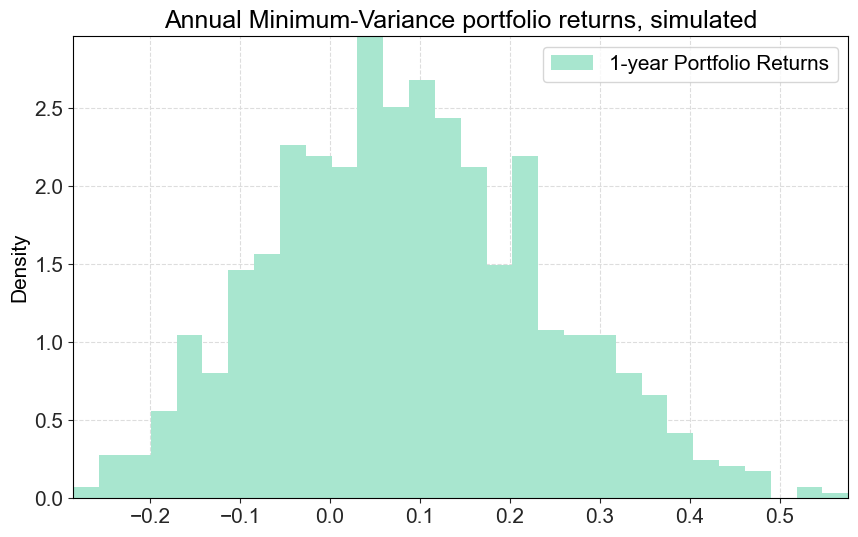

In [47]:
cov_mat_simulations = np.cov(simulated_returns_annual, rowvar=False)
min_var_weights = calculate_minimum_variance(cov_mat_simulations, max_weight)
min_var_returns = calculate_portfolio_returns(min_var_weights, simulated_returns_annual)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(min_var_returns, bins=30, density=True, label="1-year Portfolio Returns")
ax.set(title="Annual Minimum-Variance portfolio returns, simulated", ylabel="Density")
ax.legend()
plt.show()

In [48]:
min_var_returns.mean()

0    0.087112
dtype: float64

In [49]:
mean = np.mean(simulated_returns_annual, axis=0)
tangency_weights = calculate_tangency_portfolio(mean, cov_mat_simulations, risk_free_linear, max_weight)
tangency_returns = calculate_portfolio_returns(tangency_weights, simulated_returns_annual)
tangency_SR = (tangency_returns.mean()[0] - risk_free_linear) / (np.sqrt(tangency_weights @ cov_mat_simulations @ tangency_weights))
tangency_SR

0.4572500840210933

### Confirming tangency optimization function result

In [50]:
# Constraints: Long-only & max (25%; changing) weight in individual asset

S, I = simulated_returns_annual.shape
G_pf = np.vstack((np.eye(I), -np.eye(I)))
h_pf = np.hstack((max_weight * np.ones(I), np.zeros(I))) # Upper bound 25% and lower bound 0%
p = np.ones((S, 1)) / S

mv_opt = ft.MeanVariance(mean, cov_mat_simulations, G=G_pf, h=h_pf)
frontier = mv_opt.efficient_frontier(100)

# Finding max SR on efficient frontier
vols = []
for i in range(100):
    w = frontier[:, i]
    vol = np.sqrt(w @ cov_mat_simulations @ w)
    vols.append(vol)

srs = (mean @ frontier - risk_free_linear) / np.array(vols)
np.max(srs)


0.4572498448533365

### 1/N Results

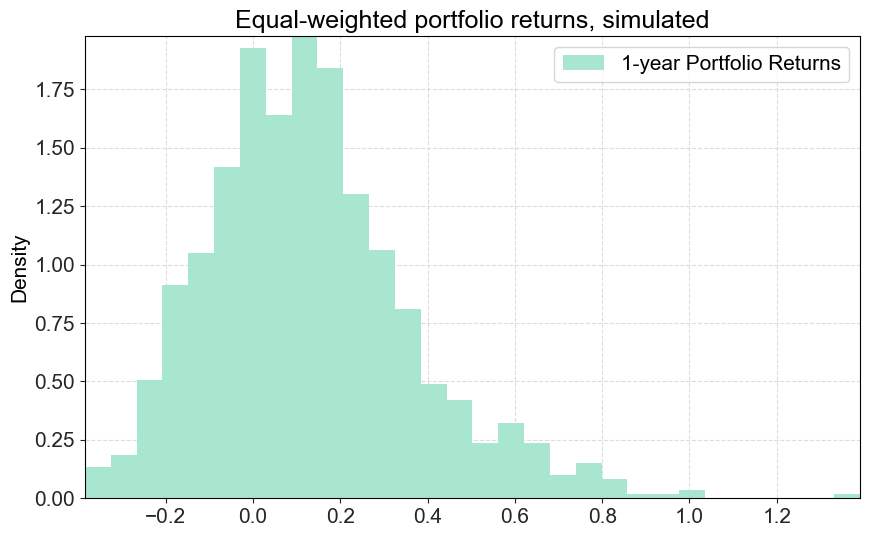

In [51]:
weight_equal = np.repeat(1/30, 30)
equal_weighted_returns = calculate_portfolio_returns(weight_equal, simulated_returns_annual)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(equal_weighted_returns, bins=30, density=True, label="1-year Portfolio Returns")
ax.set(title="Equal-weighted portfolio returns, simulated", ylabel="Density")
ax.legend()
plt.show()

In [52]:
np.average(equal_weighted_returns.values)

0.12956046256531448

### Risk budgeting - ERC

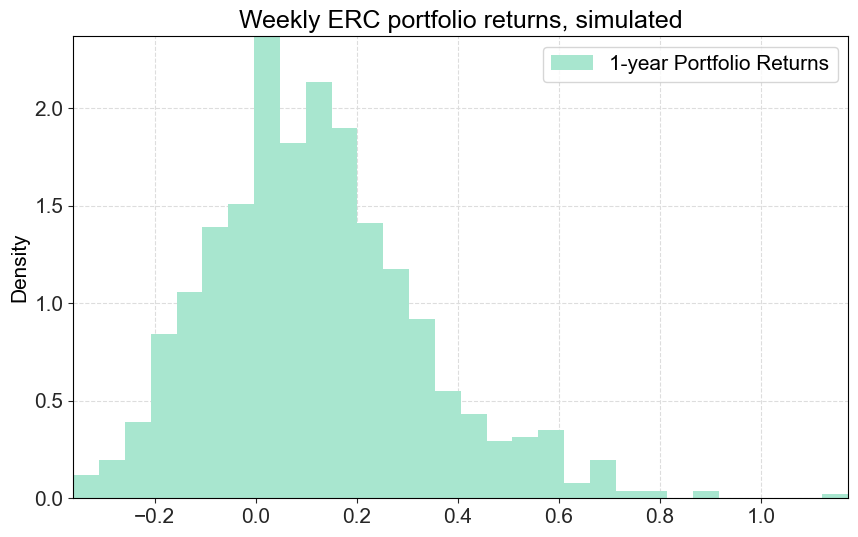

In [53]:
erc_weights = calculate_risk_parity(cov_mat_simulations)
erc_returns = calculate_portfolio_returns(erc_weights, simulated_returns_annual)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(erc_returns, bins=30, density=True, label="1-year Portfolio Returns")
ax.set(title="Weekly ERC portfolio returns, simulated", ylabel="Density")
ax.legend()
plt.show()

In [54]:
np.average(erc_returns.values)

0.11824449354357533

### Maximum Diversification

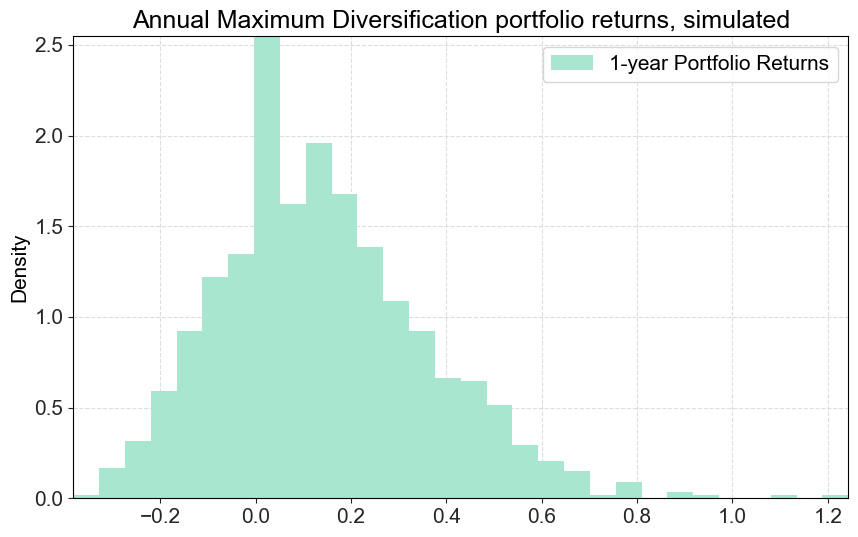

In [55]:
MD_weights = calculate_most_diversified_portfolio(cov_mat_simulations)
MD_returns = calculate_portfolio_returns(MD_weights, simulated_returns_annual)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(MD_returns, bins=30, density=True, label="1-year Portfolio Returns")
ax.set(title="Annual Maximum Diversification portfolio returns, simulated", ylabel="Density")
ax.legend()
plt.show()

In [56]:
np.average(MD_returns)

0.1418555852985976

### CVaR

In [57]:
"""
To do:
- Read Fortitudo article about demeaned PnL
"""

'\nTo do:\n- Read Fortitudo article about demeaned PnL\n'

In [58]:
# Load data and print prior P&L stats
R_df = ft.load_pnl()
stats_prior = ft.simulation_moments(R_df)
stats_prior.iloc[:, 0:2] = stats_prior.iloc[:, 0:2].mul(100)
display(np.round(stats_prior, 1))

,Mean,Volatility,Skewness,Kurtosis
Gov & MBS,-0.7,3.2,0.1,3.0
Corp IG,-0.4,3.4,0.1,3.1
Corp HY,1.9,6.1,0.2,3.0
EM Debt,2.7,7.5,0.2,3.1
DM Equity,6.4,14.9,0.4,3.1
EM Equity,8.0,26.9,0.8,4.1
Private Equity,13.7,27.8,0.7,3.8
Infrastructure,5.9,10.8,0.3,3.2
Real Estate,4.3,8.1,0.2,3.1
Hedge Funds,4.8,7.2,0.2,3.1


In [59]:
# Load data and print prior P&L stats
stats_prior = ft.simulation_moments(simulated_returns)
stats_prior.iloc[:, 0:2] = stats_prior.iloc[:, 0:2].mul(100)
display(np.round(stats_prior, 2))


,Mean,Volatility,Skewness,Kurtosis
0,0.13,2.18,-0.82,11.33
1,0.14,2.69,-0.43,24.16
2,0.15,2.99,-1.60,19.28
3,0.16,3.73,-0.12,5.09
4,0.15,3.32,-0.03,6.68
5,0.13,2.25,-0.55,8.55
6,0.17,3.89,0.29,8.97
7,0.13,2.33,-0.18,5.67
8,0.15,3.15,0.89,15.28
9,0.21,6.02,-0.29,28.53


### Simulation input

In [60]:
# Constraints: Long-only & max 25% weight in individual asset

S, I = simulated_returns_annual.shape
G_pf = np.vstack((np.eye(I), -np.eye(I)))
h_pf = np.hstack((max_weight * np.ones(I), np.zeros(I))) # Upper bound 25% and lower bound 0%
p = np.ones((S, 1)) / S

In [61]:
# Can use the following command; not recommended: ft.cvar_options['demean'] = False
cvar_opt = ft.MeanCVaR(simulated_returns_annual, G=G_pf, h=h_pf, p=p)
min_cvar_weights = cvar_opt.efficient_portfolio()
min_cvar_weights = min_cvar_weights[:, 0] # change to vector

mean_cvar_frontier = cvar_opt.efficient_frontier(50)

# Finding max SR on efficient frontier
vols = []
for i in range(50):
    w = mean_cvar_frontier[:, i]
    vol = np.sqrt(w @ cov_mat_simulations @ w)
    vols.append(vol)

srs = (mean @ mean_cvar_frontier - risk_free_linear) / np.array(vols)
max_index = np.argmax(srs) # index of maximum SR
mean_cvar_weights = mean_cvar_frontier[:, max_index]

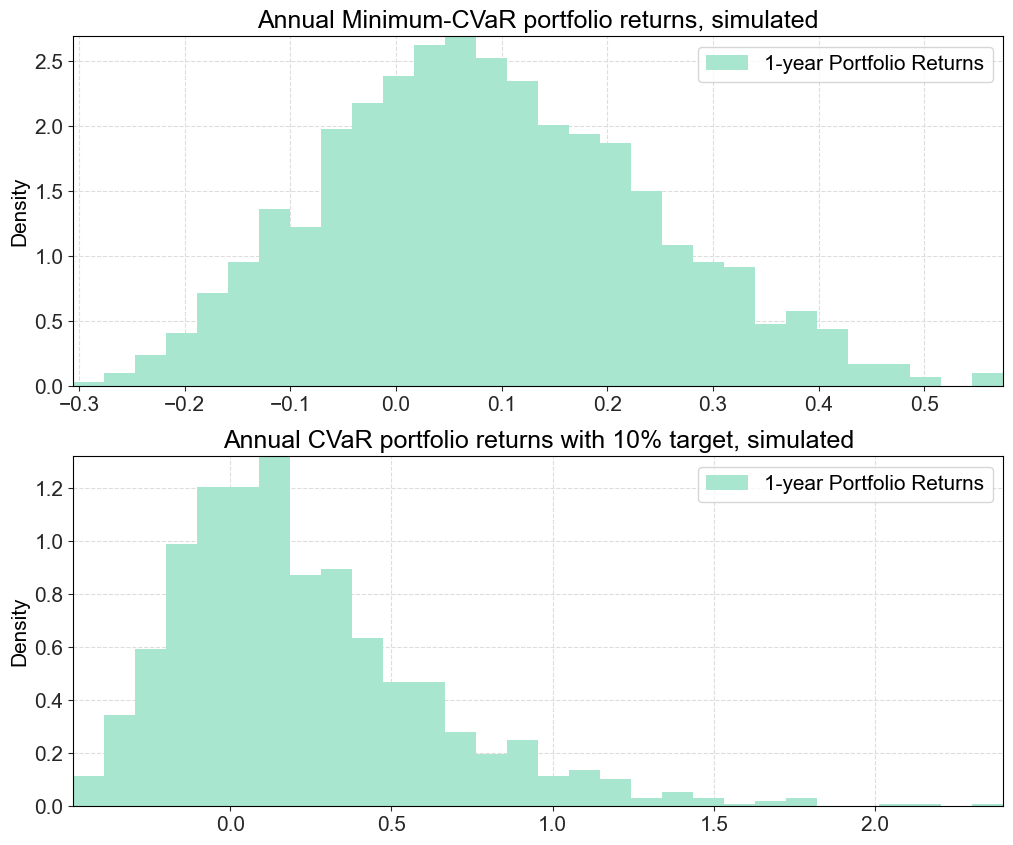

In [62]:
min_cvar_returns = calculate_portfolio_returns(min_cvar_weights, simulated_returns_annual)
mean_cvar_returns = calculate_portfolio_returns(mean_cvar_weights, simulated_returns_annual)

# Plotting
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].hist(min_cvar_returns, bins=30, density=True, label="1-year Portfolio Returns")
ax[0].set(title="Annual Minimum-CVaR portfolio returns, simulated", ylabel="Density")
ax[0].legend()

ax[1].hist(mean_cvar_returns, bins=30, density=True, label="1-year Portfolio Returns")
ax[1].set(title="Annual CVaR portfolio returns with 10% target, simulated", ylabel="Density")
ax[1].legend()

plt.show()

In [63]:
print(min_cvar_returns.mean())
print(mean_cvar_returns.mean())

0    0.087776
dtype: float64
0    0.222573
dtype: float64


In [64]:
print(calculate_conditional_value_at_risk(min_cvar_returns.values, 0.1))
print(calculate_conditional_value_at_risk(mean_cvar_returns.values, 0.1))

[-0.16152278]
[-0.29837782]


## Comparison of methods

In [65]:
risk_free_linear = np.exp(risk_free) - 1
risk_free_linear

0.04489999999999994

In [67]:
results = {"Market cap": mkt_cap_returns,
           "1/N": equal_weighted_returns,
           "ERC": erc_returns,
           "Max. Diversification": MD_returns,
           "Min-Var": min_var_returns,
           "Mean-Var": tangency_returns,
           "Min-CVaR": min_cvar_returns,
           "Mean-CVaR": mean_cvar_returns
          }

portfolio_results = pd.DataFrame(index=["Mean", "SD", "Skewness", "Kurtosis", "SR", "Sortino", "CVaR 5%", "Max. Drawdown"], columns=["Market cap", "1/N", "ERC", "Max. Diversification", "Min-Var", "Mean-Var", "Min-CVaR", "Mean-CVaR"])

for key, value in results.items():
    annual_returns = value
    portfolio_results.loc["Mean", key] = annual_returns.mean()[0] * 100
    portfolio_results.loc["SD", key] = annual_returns.std()[0] * 100
    portfolio_results.loc["Skewness", key] = annual_returns.skew()[0]
    portfolio_results.loc["Kurtosis", key] = annual_returns.kurt()[0]
    portfolio_results.loc["SR", key] = (annual_returns.mean()[0] - risk_free_linear) / annual_returns.std()[0]
    portfolio_results.loc["Sortino", key] = MyFunctions.calculate_sortino_ratio(annual_returns.iloc[:, 0].values)
    portfolio_results.loc["STARR", key] = MyFunctions.calculate_starr_ratio(annual_returns.iloc[:, 0].values, risk_free_linear, 0.05)
    portfolio_results.loc["CVaR 5%", key] = calculate_conditional_value_at_risk(annual_returns.iloc[:, 0].values, 0.05) * 100
    portfolio_results.loc["Max. Drawdown", key] = annual_returns.min()[0] * 100

portfolio_results = portfolio_results.map(lambda x: float(x) if isinstance(x, (list, np.ndarray)) else x)
portfolio_results.round(2)

,Market cap,1/N,ERC,Max. Diversification,Min-Var,Mean-Var,Min-CVaR,Mean-CVaR
Mean,10.99,12.96,11.82,14.19,8.71,18.45,8.78,22.26
SD,20.70,23.46,20.98,21.94,15.09,30.53,15.27,40.07
Skewness,0.54,0.82,0.68,0.67,0.23,1.02,0.26,1.26
Kurtosis,0.32,1.31,0.89,0.92,-0.24,1.91,-0.23,2.51
SR,0.31,0.36,0.35,0.44,0.28,0.46,0.28,0.44
Sortino,0.81,0.90,0.87,1.05,0.81,1.13,0.82,1.14
CVaR 5%,-24.73,-26.00,-24.16,-23.47,-19.59,-29.77,-19.31,-35.62
Max. Drawdown,-38.73,-38.54,-36.07,-38.22,-28.54,-44.42,-30.56,-48.69


# Stress-test with mean

Idea: 
- Base model is not necessarily the true data generating process
- Want to test robustness of optimization approaches by stress-testing the mean-vector
- Need to vary mean-vector over plausible interval. I will get this interval by assuming market distribution is log-normal, estimating a cov_mat scaled by historical observations i.e. approach from using a sample mean. In reality, the sample mean varies over time, so I believe using the constant SR derived mean-vector as the mean is fine
- Test how the base-case optimized weights perform in stress-test scenarios. Calculate the SR in each stress-test and in the end compare distribution of SRs across stress-test scenarios

In [68]:
expected_return_weekly*52

array([0.06751081, 0.0729986 , 0.07630297, 0.08428288, 0.07982914,
       0.06825667, 0.08603139, 0.0691417 , 0.07803613, 0.10905173,
       0.09010396, 0.09619567, 0.08034594, 0.08572533, 0.10816211,
       0.09628393, 0.08858491, 0.12107404, 0.09559884, 0.07921461,
       0.07138022, 0.07604125, 0.07763428, 0.07053329, 0.07804847,
       0.07567767, 0.07261718, 0.07831753, 0.07868773, 0.06978805])

In [69]:
(target_SR_weekly * np.sqrt(np.diag(np.cov(log_returns, rowvar=False))) + risk_free_weekly)*52

array([0.06609641, 0.06919468, 0.0760472 , 0.08456801, 0.07879766,
       0.06757906, 0.08246295, 0.0699111 , 0.07642577, 0.10069819,
       0.0843382 , 0.09560399, 0.08024221, 0.08385742, 0.10271896,
       0.08685273, 0.08634735, 0.12346993, 0.08889801, 0.07209881,
       0.0699758 , 0.07528421, 0.07715755, 0.07116653, 0.07748818,
       0.07429412, 0.07241153, 0.07334491, 0.07655394, 0.07010978])

In [70]:
np.mean(log_returns, axis=0)*52

array([ 0.05772563,  0.06836072,  0.09021153,  0.12887066,  0.04023683,
        0.06706771,  0.05926925,  0.08148182,  0.05111444, -0.0185019 ,
        0.14963762,  0.08233439,  0.13469897,  0.06498712,  0.18416328,
        0.09802103,  0.10563236, -0.0213517 ,  0.04642271,  0.07517022,
        0.04548167,  0.16486766,  0.2065395 ,  0.03649746,  0.07147173,
        0.10264192,  0.14152857,  0.11999537,  0.11671047,  0.09770368])

In [71]:
obs = log_returns.shape[0]
cov_mat_historical = np.cov(log_returns, rowvar=False)
stress_test_scenarios = 100
stress_test_means = stats.multivariate_normal.rvs(expected_return_weekly, cov_mat_historical / obs, size=stress_test_scenarios)
stress_test_means.shape

(100, 30)

In [73]:
# Testing performance in stress-test scenarios

stress_test_SRs = {"Market cap": [],
                   "1/N": [],
                   "ERC": [],
                   "Max. Diversification": [],
                   "Min-Var": [],
                   "Mean-Var": [],
                   "Min-CVaR": [],
                   "Mean-CVaR": []
                  }

final_shape = (1000, 52, 30)

optimized_weights = {"Market cap": industry_mc_weights,
                     "1/N": weight_equal,
                     "ERC": erc_weights,
                     "Max. Diversification": MD_weights,
                     "Min-Var": min_var_weights,
                     "Mean-Var": tangency_weights,
                     "Min-CVaR": min_cvar_weights,
                     "Mean-CVaR": mean_cvar_weights
                    }

for i in range(stress_test_scenarios):
    mean_vector = stress_test_means[i]
    stress_test_returns = simulated_returns_log - expected_return_weekly + mean_vector
    stress_test_returns = stress_test_returns.reshape(final_shape)
    stress_test_returns = stress_test_returns.sum(axis=1) #converting to annual returns by summing over weeks, shape(1000, 30)
    stress_test_returns = np.exp(stress_test_returns) - 1 #convert to linear returns
    for key, value in optimized_weights.items():
        weights = value
        portfolio_return = calculate_portfolio_returns(weights, stress_test_returns).iloc[:, 0].values # 1000 annual portfolio returns
        annual_SR = (np.mean(portfolio_return) - risk_free_linear) / np.std(portfolio_return)
        stress_test_SRs[key].append(annual_SR) # saving SR

stress_test_SRs = pd.DataFrame(stress_test_SRs)

In [74]:
stress_test_SRs

,Market cap,1/N,ERC,Max. Diversification,Min-Var,Mean-Var,Min-CVaR,Mean-CVaR
0,0.305876,0.282142,0.309766,0.365055,0.478911,0.273040,0.459711,0.197903
1,0.526714,0.584105,0.584417,0.704503,0.554558,0.688854,0.535466,0.616469
2,0.274973,0.397649,0.384103,0.619074,0.328814,0.603237,0.345402,0.487776
3,0.325735,0.258202,0.214694,0.240604,0.011935,0.337330,0.043573,0.407909
4,0.035468,0.162613,0.138190,0.275274,0.085963,0.311560,0.095810,0.359995
...,...,...,...,...,...,...,...,...
95,0.404239,0.281253,0.285923,0.404500,0.210455,0.386110,0.217529,0.307957
96,0.254084,0.243436,0.250519,0.214732,0.351994,0.238547,0.389160,0.290375
97,0.293516,0.451636,0.444277,0.548668,0.377768,0.542740,0.376311,0.541499
98,0.526705,0.349655,0.386665,0.397558,0.607933,0.261846,0.594867,0.246733


In [75]:
stress_test_results = pd.DataFrame(index=["Mean", "SD", "Skewness", "Kurtosis"], columns=["Market cap", "1/N", "ERC", "Max. Diversification", "Min-Var", "Mean-Var", "Min-CVaR", "Mean-CVaR"])
stress_test_results = stress_test_results.transpose()
stress_test_results["Mean"] = stress_test_SRs.mean()
stress_test_results["SD"] = stress_test_SRs.std()
stress_test_results["Skewness"] = stress_test_SRs.skew()
stress_test_results["Kurtosis"] = stress_test_SRs.kurt()
stress_test_results = stress_test_results.transpose()
stress_test_results.round(2)

,Market cap,1/N,ERC,Max. Diversification,Min-Var,Mean-Var,Min-CVaR,Mean-CVaR
Mean,0.33,0.38,0.36,0.46,0.28,0.48,0.29,0.46
SD,0.28,0.24,0.25,0.24,0.32,0.21,0.32,0.19
Skewness,-0.09,0.01,0.03,-0.24,0.02,-0.41,-0.01,-0.34
Kurtosis,0.30,-0.00,-0.06,0.26,-0.18,0.66,-0.20,0.63


In [76]:
stress_test_SRs.columns

Index(['Market cap', '1/N', 'ERC', 'Max. Diversification', 'Min-Var', 'Mean-Var', 'Min-CVaR', 'Mean-CVaR'], dtype='object')

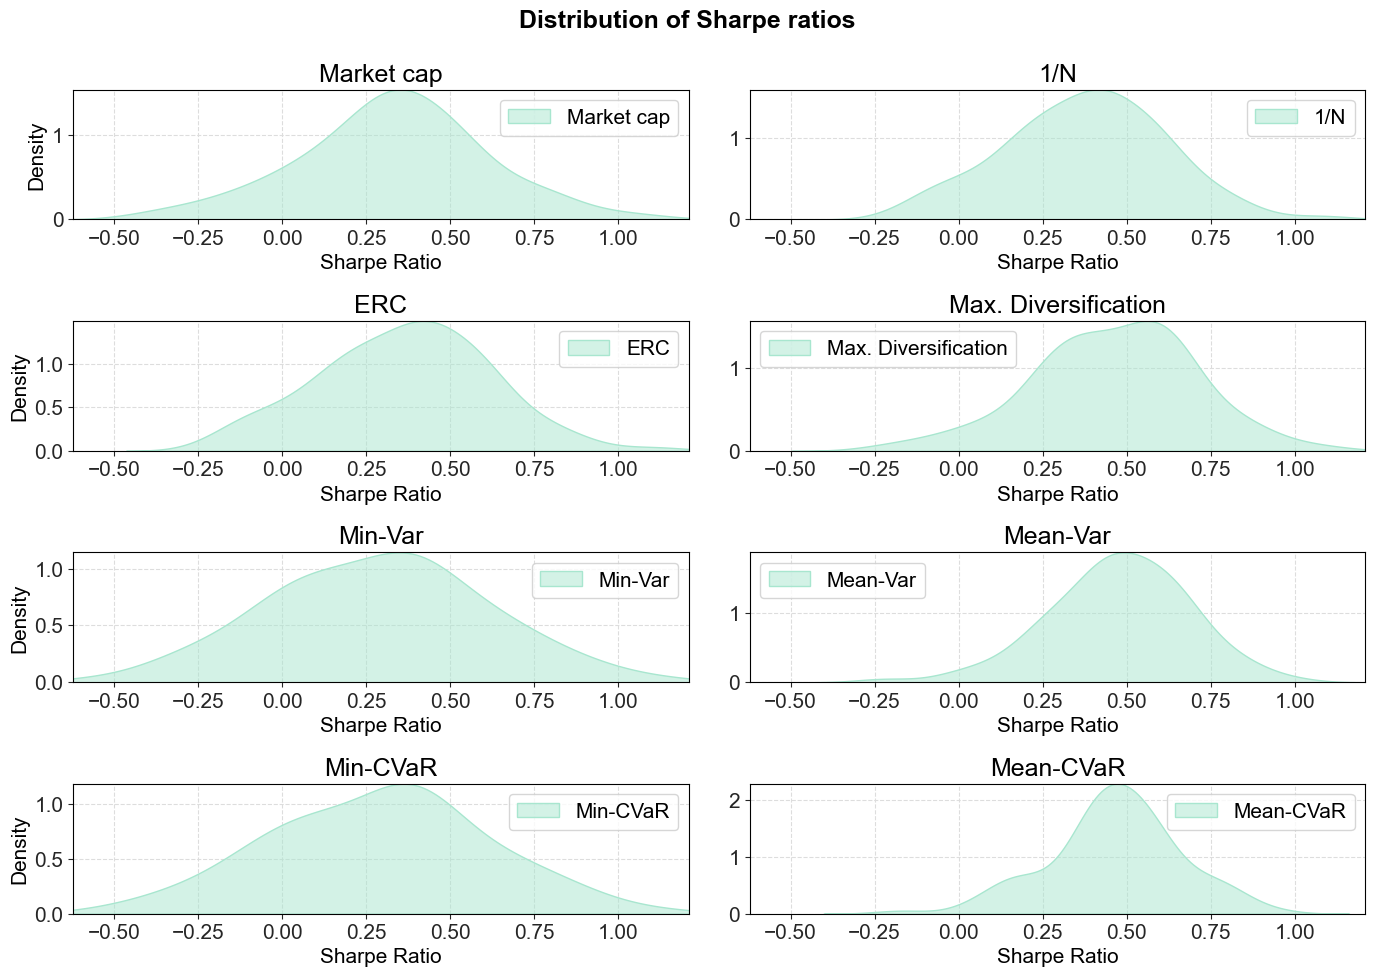

In [80]:
fig, axes = plt.subplots(4, 2, figsize=(14, 10))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# First find the min and max across all columns to standardize x-axis
min_value = float('inf')
max_value = float('-inf')
for column in stress_test_SRs.columns:
    min_value = min(min_value, stress_test_SRs[column].min())
    max_value = max(max_value, stress_test_SRs[column].max())

# Add some padding to the limits
x_padding = (max_value - min_value) * 0.05
x_min = min_value - x_padding
x_max = max_value + x_padding

# Create plots
for i, column in enumerate(stress_test_SRs.columns):
    SR = stress_test_SRs[column]
    sns.kdeplot(SR, fill=True, alpha=0.5, ax=axes[i], label=column)
    
    # Set consistent x-axis limits
    axes[i].set_xlim(x_min, x_max)
    
    # Add titles
    axes[i].set_title(f"{column}")
    axes[i].set_xlabel("Sharpe Ratio")
    
    # Only set ylabel for left-side plots (even indices)
    if i % 2 == 0:
        axes[i].set_ylabel("Density")
    else:
        axes[i].set_ylabel("")
    
    axes[i].legend()

# Add overall title
fig.suptitle("Distribution of Sharpe ratios", weight="bold")

plt.tight_layout()
# Adjust the layout to make room for the suptitle
plt.subplots_adjust(top=0.9)
plt.show()

# Views - Entropy Pooling

In [81]:
from codelib.statistics.fully_flexible_views import * 


In [82]:
mu = np.array([0.0, 0.0])
cov_mat = np.array([[1.0, 0.8],
                    [0.8, 1.0]])

num_sim = 10000
prior_data = np.random.multivariate_normal(mu, cov_mat, size=num_sim)
init_probs = np.repeat(1.0 / num_sim, num_sim)

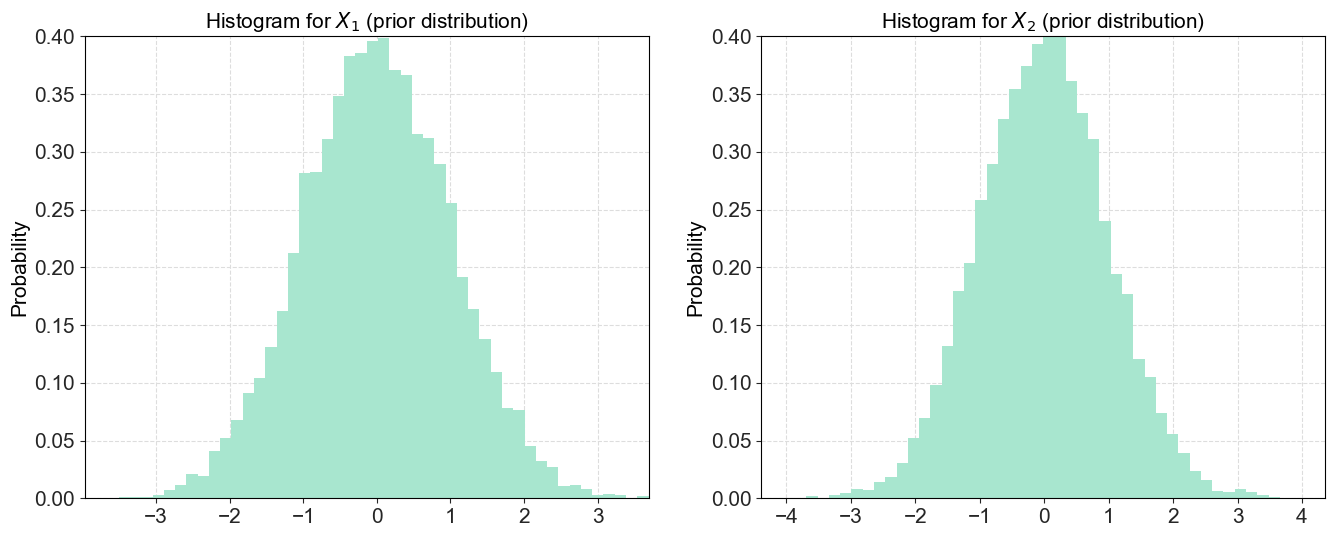

In [83]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

for i in range(2):
    ax[i].hist(prior_data[:, i], bins=50, density=True)
    ax[i].set_title('Histogram for $X_{}$ (prior distribution)'.format(i + 1), size=15)
    ax[i].set_ylabel('Probability', size=15);
    ax[i].set_ylim([0.0, 0.4]);

In [84]:
"""
Class that implements the above method
"""

mean_view = MeanView('eq', prior_data[:, 0], 0.5)
vol_view = VolatilityView('eq', prior_data[:, 0], 0.5, 0.1)

all_views = [mean_view, vol_view]

view_solver = ProbabilitySolver(init_probs, all_views)
view_probs = view_solver.minimize_entropy()

In [85]:
prior_data.shape

(10000, 2)

In [86]:
from statsmodels.stats.weightstats import DescrStatsW # for wgt std

posterior_mean = np.average(prior_data, axis=0, weights=view_probs)
weighted_stats = DescrStatsW(prior_data, weights=view_probs, ddof=0)

In [87]:
posterior_mean

array([0.49999954, 0.3895781 ])

In [88]:
print(weighted_stats.mean)
print(weighted_stats.std)

[0.49999954 0.3895781 ]
[0.09999856 0.5728913 ]


## Fortitudo implementation

In [89]:
sample = np.random.normal(0.1, 0.2, size=10_000)

cvar_5 = calculate_conditional_value_at_risk(sample, p=0.05)
std_nrm = stats.norm.ppf(0.10)

m = sample.mean()
sd = sample.std()
rf = 0.01

sr = (m - rf) / sd
starr = (m - rf) / (cvar_5 / std_nrm)

print(sr)
print(starr)

0.43933776074026015
0.3585784174117965


In [90]:
0.09 / 0.2

0.44999999999999996

In [91]:
cvar_5

-0.3125105733908696

In [92]:
std_nrm

-1.2815515655446004

In [93]:
0.2 * std_nrm

-0.2563103131089201

In [94]:
s = sample[sample <= np.quantile(sample, 0.05)]
s.mean()
        

-0.31251057339086946

In [95]:
(m - rf) / (cvar_5)

-0.279800225798497